https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

In [ ]:
!nvidia-smi                                 # 사용하는 GPU를 확인

import numpy as np                          
import pandas as pd                         # data analysis and manipulation tool
import os 
from glob import glob 
import seaborn as sns                       # visualization tool
from PIL import Image                       # Python Imaging Libary, pillow module
np.random.seed(123)

Sun Aug 22 07:45:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools                                    # for looping efficient iteration
import tensorflow as tf 
from tensorflow import keras
import keras 
from keras.utils.np_utils import to_categorical # 레이블을 단일 열로 변환하는 데 사용
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers import BatchNormalization

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"          #GPU사용을 설정 

In [ ]:
#google drive의 사용권한 확인
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#파일 확인 
base_path = "/content/gdrive/My Drive/Colab Notebooks/skin_cancer"
print(os.listdir('/content/gdrive/My Drive/Colab Notebooks/skin_cancer'))

base_skin_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks','/content/gdrive/My Drive/Colab Notebooks/skin_cancer')
print(base_skin_dir)

['HAM10000_metadata.csv', 'hmnist_8_8_L.csv', '.DS_Store', '._.DS_Store', 'HAM10000_images_part_1', 'HAM10000_images_part_2']
/content/gdrive/My Drive/Colab Notebooks/skin_cancer


In [ ]:
# 두 폴더의 이미지를 하나의 사전으로 병합

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv':'Melanocytic nevi',                            # 멜라닌 세포 모반
    'mel': 'Melanoma',                                  # 흑색종
    'bkl': 'Benign keratosis-like lesions ',            # 양성 각화증 유사 병변
    'bcc': 'Basal cell carcinoma',                      # 기저 세포암
    'akiec': 'Actinic keratoses',                       # 광선 각화증
    'vasc': 'Vascular lesions',                         # 혈관 병변
    'df': 'Dermatofibroma'                              # 피부섬유종
}

In [ ]:
#메타데이터의 csv에서 읽기
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

In [ ]:
# 일부 새 열(이미지 경로, 사람이 읽을 수 있는 이름)을 만들고 검토
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes

print(tile_df.sample(5))

        lesion_id      image_id  ...          cell_type cell_type_idx
9725  HAM_0004376  ISIC_0024843  ...  Actinic keratoses             0
6059  HAM_0003024  ISIC_0024768  ...   Melanocytic nevi             4
4540  HAM_0001659  ISIC_0026564  ...   Melanocytic nevi             4
3817  HAM_0004625  ISIC_0029346  ...   Melanocytic nevi             4
7914  HAM_0000443  ISIC_0034271  ...   Melanocytic nevi             4

[5 rows x 10 columns]


In [ ]:
#데이터 집합에 대한 일반 통계 가져오기
print(tile_df.describe(exclude=[np.number]))

          lesion_id  ...         cell_type
count         10015  ...             10015
unique         7470  ...                 7
top     HAM_0003789  ...  Melanocytic nevi
freq              6  ...              6705

[4 rows x 8 columns]


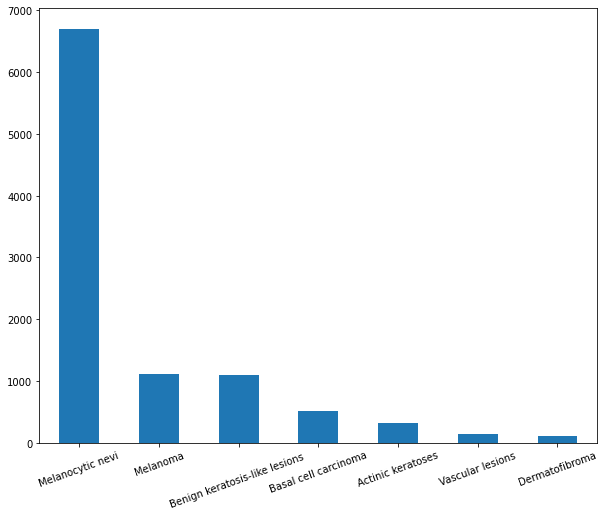

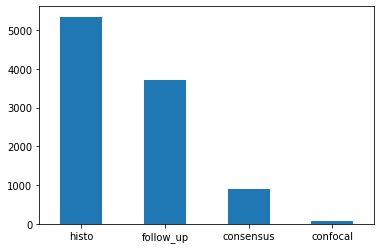

In [ ]:
#그래프를 이용해서 csv 파일 데이터 분석 
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize= (10, 8))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)
plt.xticks(rotation = 20)
plt.show()

tile_df['dx_type'].value_counts().plot(kind='bar')
plt.xticks(rotation = 0)
plt.show()

In [ ]:
#이미지를 가지고 오기
# map(function, iterable): 여러 개의 데이터를 한 번에 다른 형태로 변환하기 위해 사용
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

In [ ]:
print(tile_df)

         lesion_id  ...                                              image
0      HAM_0000118  ...  [[[190, 153, 194], [192, 154, 196], [191, 153,...
1      HAM_0000118  ...  [[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...
2      HAM_0002730  ...  [[[185, 127, 137], [189, 133, 147], [194, 136,...
3      HAM_0002730  ...  [[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...
4      HAM_0001466  ...  [[[134, 90, 113], [147, 102, 125], [159, 115, ...
...            ...  ...                                                ...
10010  HAM_0002867  ...  [[[155, 137, 148], [154, 136, 147], [151, 134,...
10011  HAM_0002867  ...  [[[5, 6, 4], [6, 7, 4], [7, 8, 6], [7, 7, 5], ...
10012  HAM_0002867  ...  [[[112, 102, 105], [127, 116, 117], [141, 127,...
10013  HAM_0000239  ...  [[[159, 122, 146], [159, 123, 141], [154, 112,...
10014  HAM_0003521  ...  [[[177, 147, 133], [176, 143, 132], [177, 143,...

[10015 rows x 11 columns]


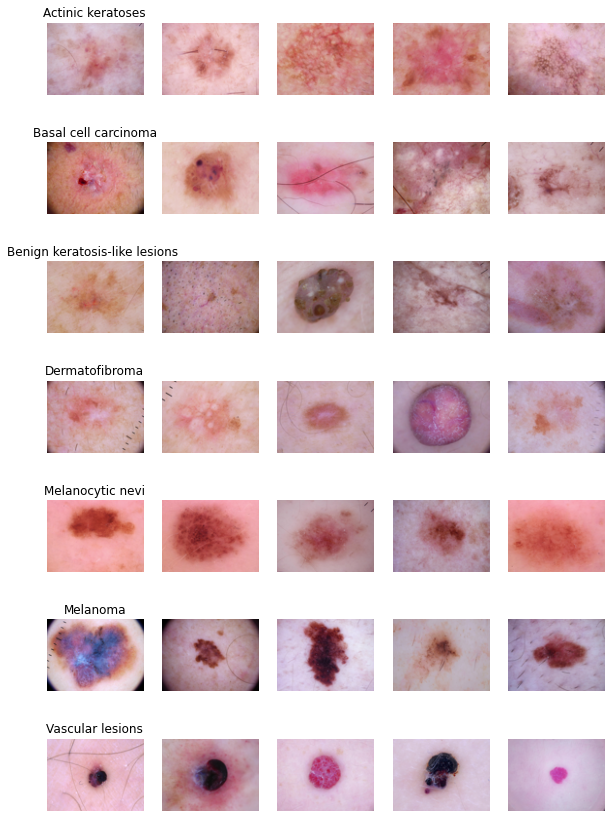

In [ ]:
#가지고 온 이미지를 이용해서 샘플을 보여줌
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (10, 15))
for n_axs, (type_name, type_rows) in zip(m_axs, tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)

    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

fig.savefig('category_samples.png', dpi=300)
plt.show()

In [ ]:
# 이미지 사이즈 및 사진량
print(tile_df['image'].map(lambda x: x.shape).value_counts())
y = tile_df.cell_type_idx


from sklearn.model_selection import train_test_split

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.25)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

(75, 100, 3)    10015
Name: image, dtype: int64


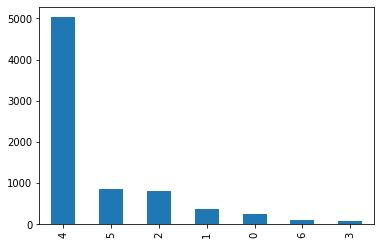

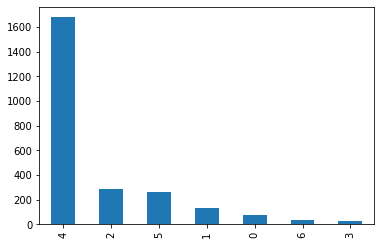

In [ ]:
# 레이블에 단일 핫 인코딩 수행
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

y_train_o.value_counts().plot(kind='bar')
plt.show()

y_test_o.value_counts().plot(kind='bar')
plt.show()

In [ ]:
#모델 생성(DensNet을 모티브하여 만든 모델)
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))                                            # dropoup 시켜서 정규화 시켜줌


model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))   #relu를 사용하여서 Gradient Vanicing문제 해결
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))   #Same은 출력크기를 입력크기와 같게 유지함 
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
#그래프 
batch_size = 32                             # 작업: 이 변수를 사용하여 더 많은 실험을 수행
epochs = 12

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()